In [4]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df = pd.read_csv('MMM _ Channel Test _ Dataset - Sheet1.csv')
df.head()

,date,amazon_ads_c,facebook_ads_c,google_ads_c,microsoft_ads_c,sales
0,1/1/2022,0.0,NaN,2012.716790,0.0,1023.0
1,1/2/2022,0.0,NaN,2513.760762,0.0,1248.0
2,1/3/2022,0.0,NaN,2866.456807,0.0,1468.0
3,1/4/2022,0.0,NaN,9075.538446,0.0,2807.0
4,1/5/2022,0.0,NaN,8763.008392,0.0,2676.0


In [6]:
df = df.fillna(0)

In [7]:
df['date'] = pd.to_datetime(df.date)

In [8]:
df['weekday'] = df['date'].dt.dayofweek
df['yearday'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month

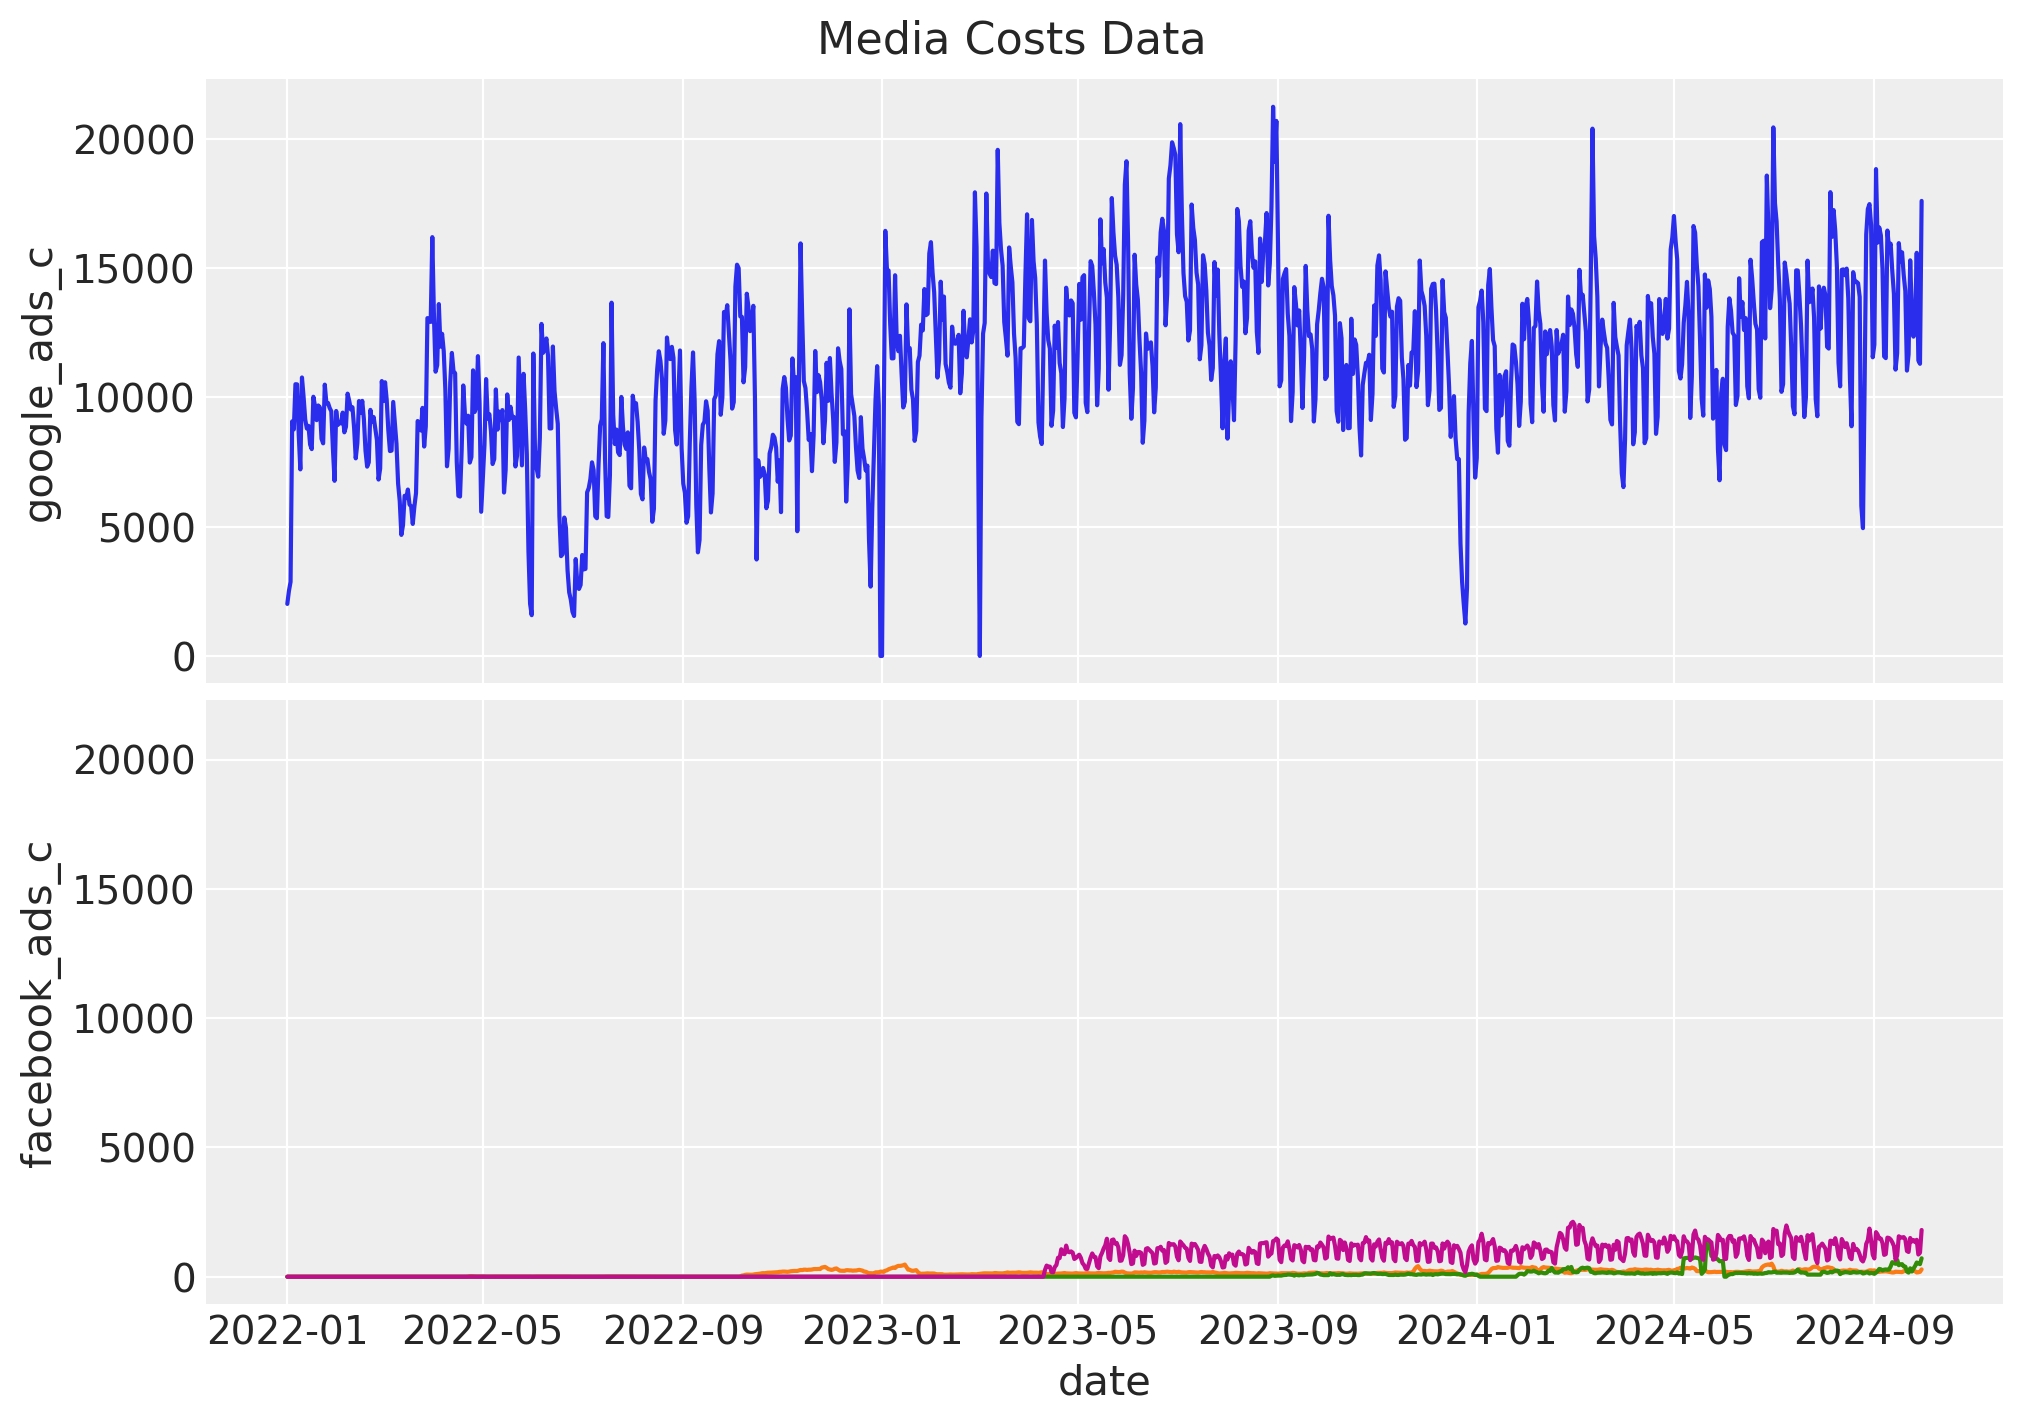

In [9]:
import seaborn as sns
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date", y="google_ads_c", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date", y="facebook_ads_c", data=df, color="C1", ax=ax[1])
sns.lineplot(x="date", y="amazon_ads_c", data=df, color="C2", ax=ax[1])
sns.lineplot(x="date", y="microsoft_ads_c", data=df, color="C3", ax=ax[1])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

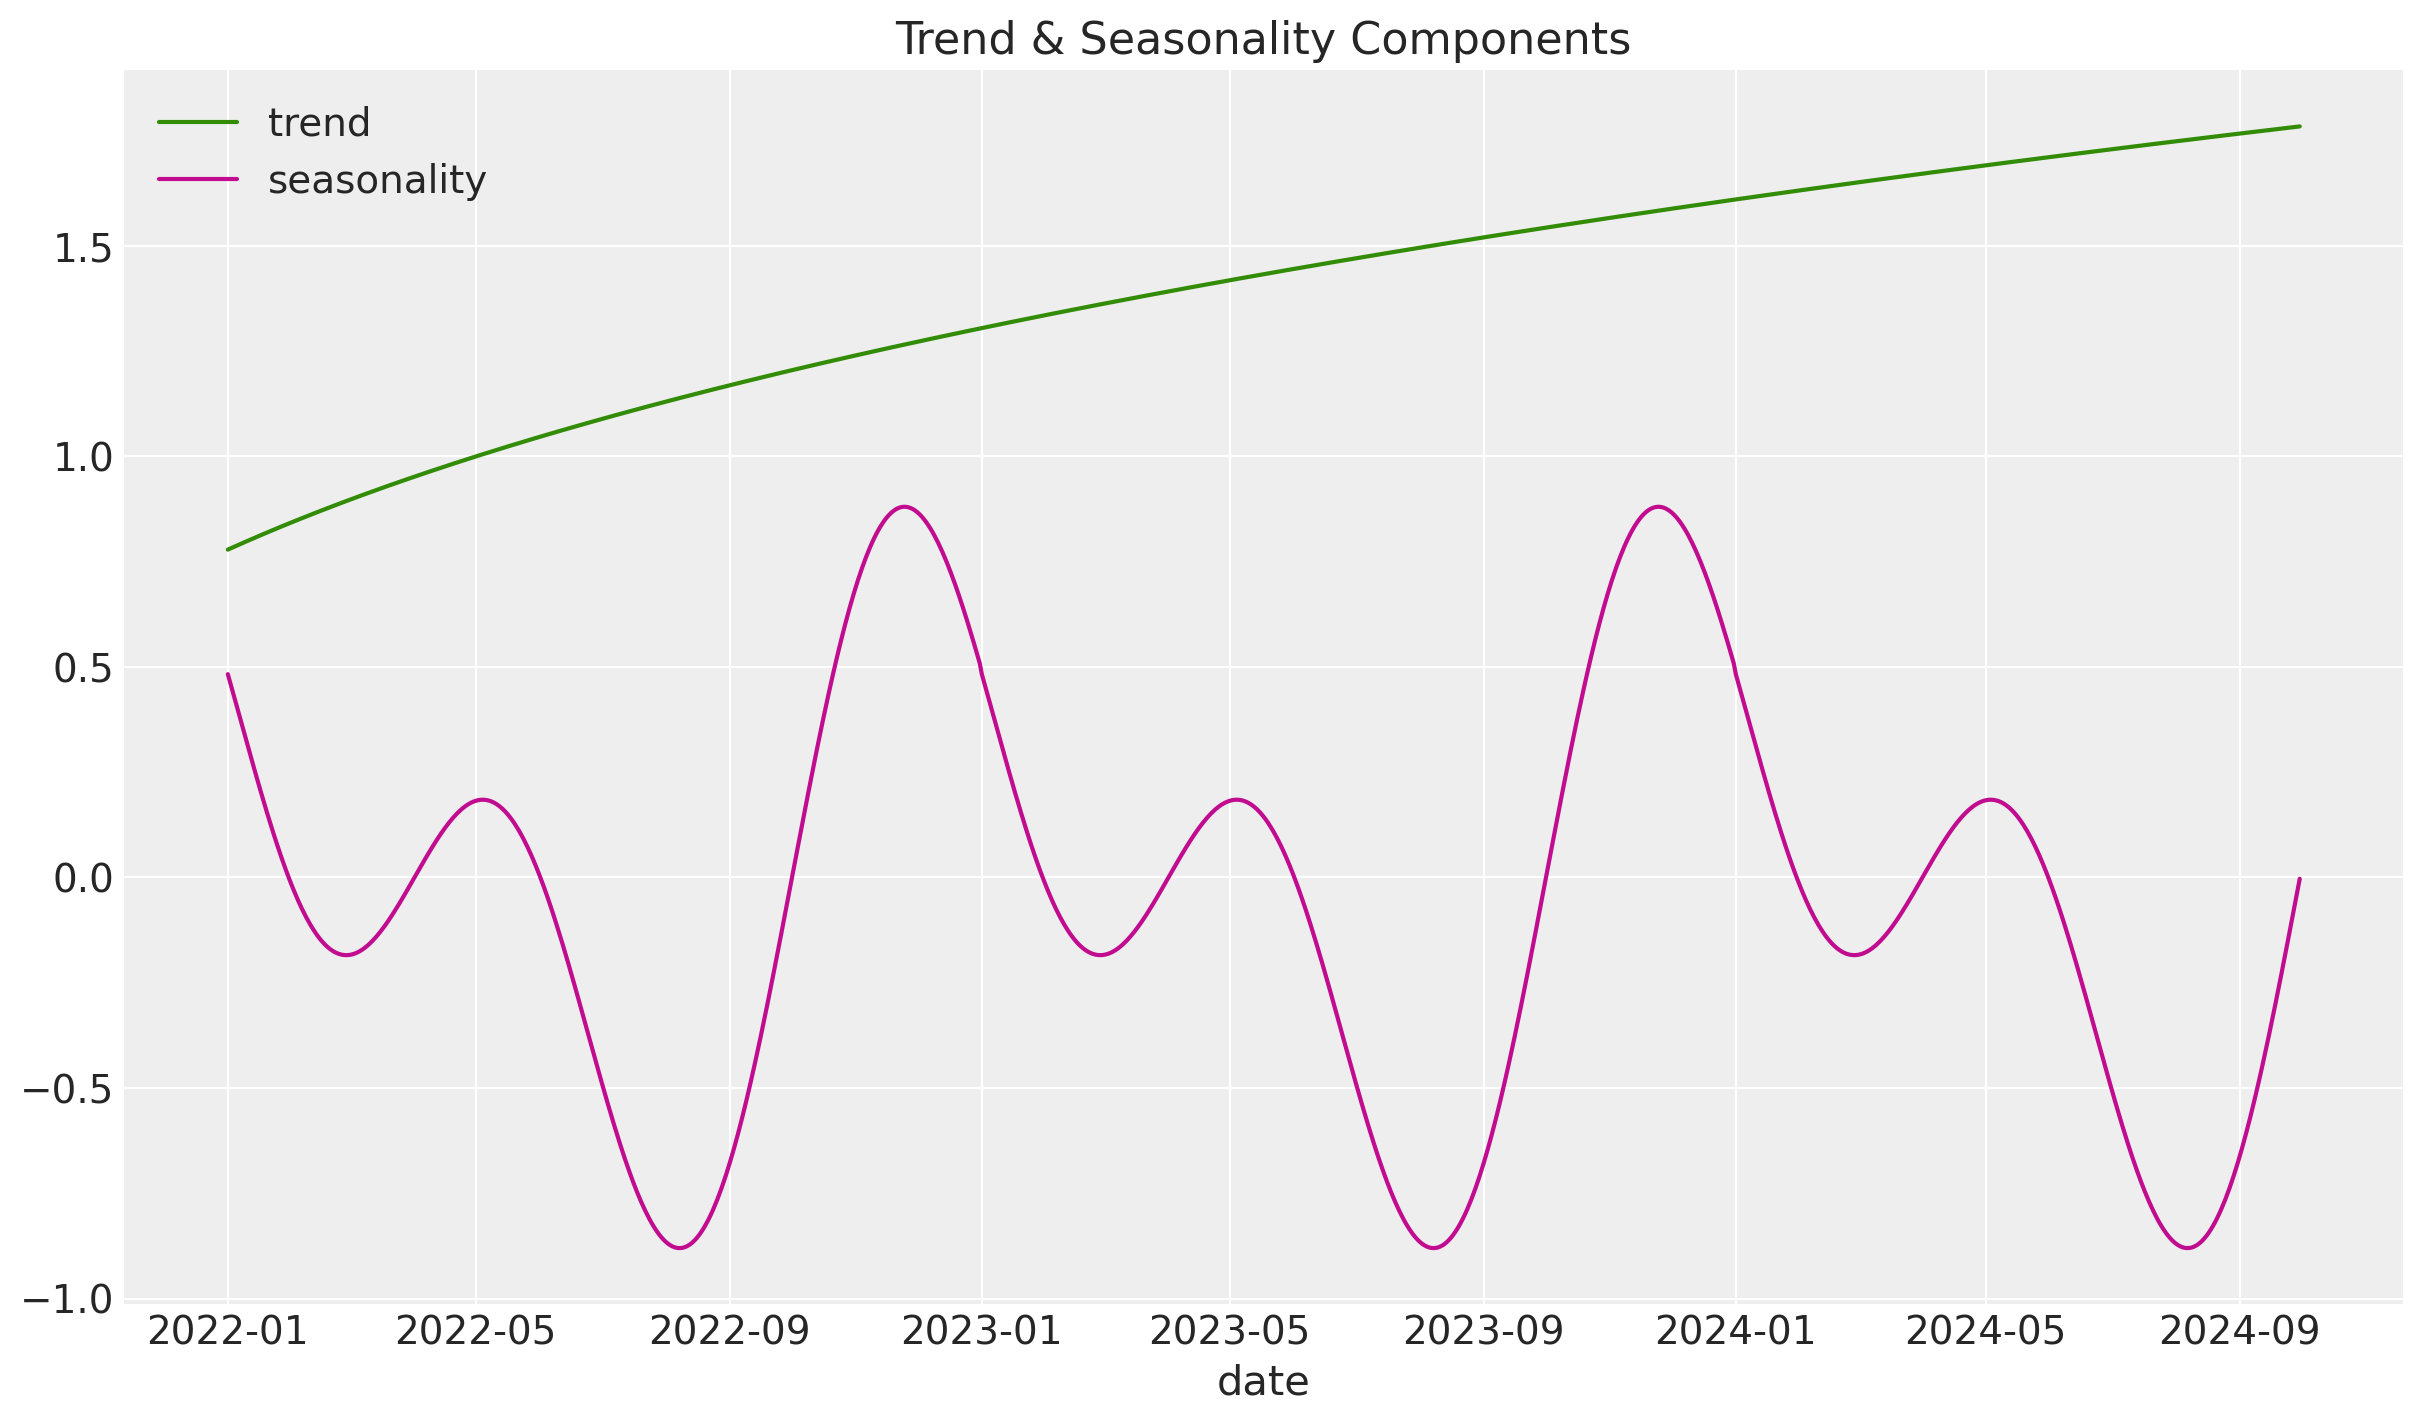

In [10]:
n = df.shape[0]
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["yearday"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["yearday"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

In [11]:
# apply geometric adstock transformation
alpha1: float = 0.4
alpha2: float = 0.2
alpha3: float = 0.2
alpha4: float = 0.1

df["gads_adstock"] = (
    geometric_adstock(x=df["google_ads_c"].to_numpy(), alpha=alpha1, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["fb_adstock"] = (
    geometric_adstock(x=df["facebook_ads_c"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["am_adstock"] = (
    geometric_adstock(x=df["amazon_ads_c"].to_numpy(), alpha=alpha3, l_max=8, normalize=True)
    .eval()
    .flatten()
)

df["mc_adstock"] = (
    geometric_adstock(x=df["microsoft_ads_c"].to_numpy(), alpha=alpha4, l_max=8, normalize=True)
    .eval()
    .flatten()
)

In [12]:
# apply saturation transformation
lam1: float = 4.0
lam2: float = 3.0
lam3: float = 2.0
lam4: float = 1.0

df["gads_adstock_saturated"] = logistic_saturation(
    x=df["gads_adstock"].to_numpy(), lam=lam1
).eval()

df["fb_adstock_saturated"] = logistic_saturation(
    x=df["fb_adstock"].to_numpy(), lam=lam2
).eval()

df["am_adstock_saturated"] = logistic_saturation(
    x=df["am_adstock"].to_numpy(), lam=lam3
).eval()

df["mc_adstock_saturated"] = logistic_saturation(
    x=df["mc_adstock"].to_numpy(), lam=lam4
).eval()

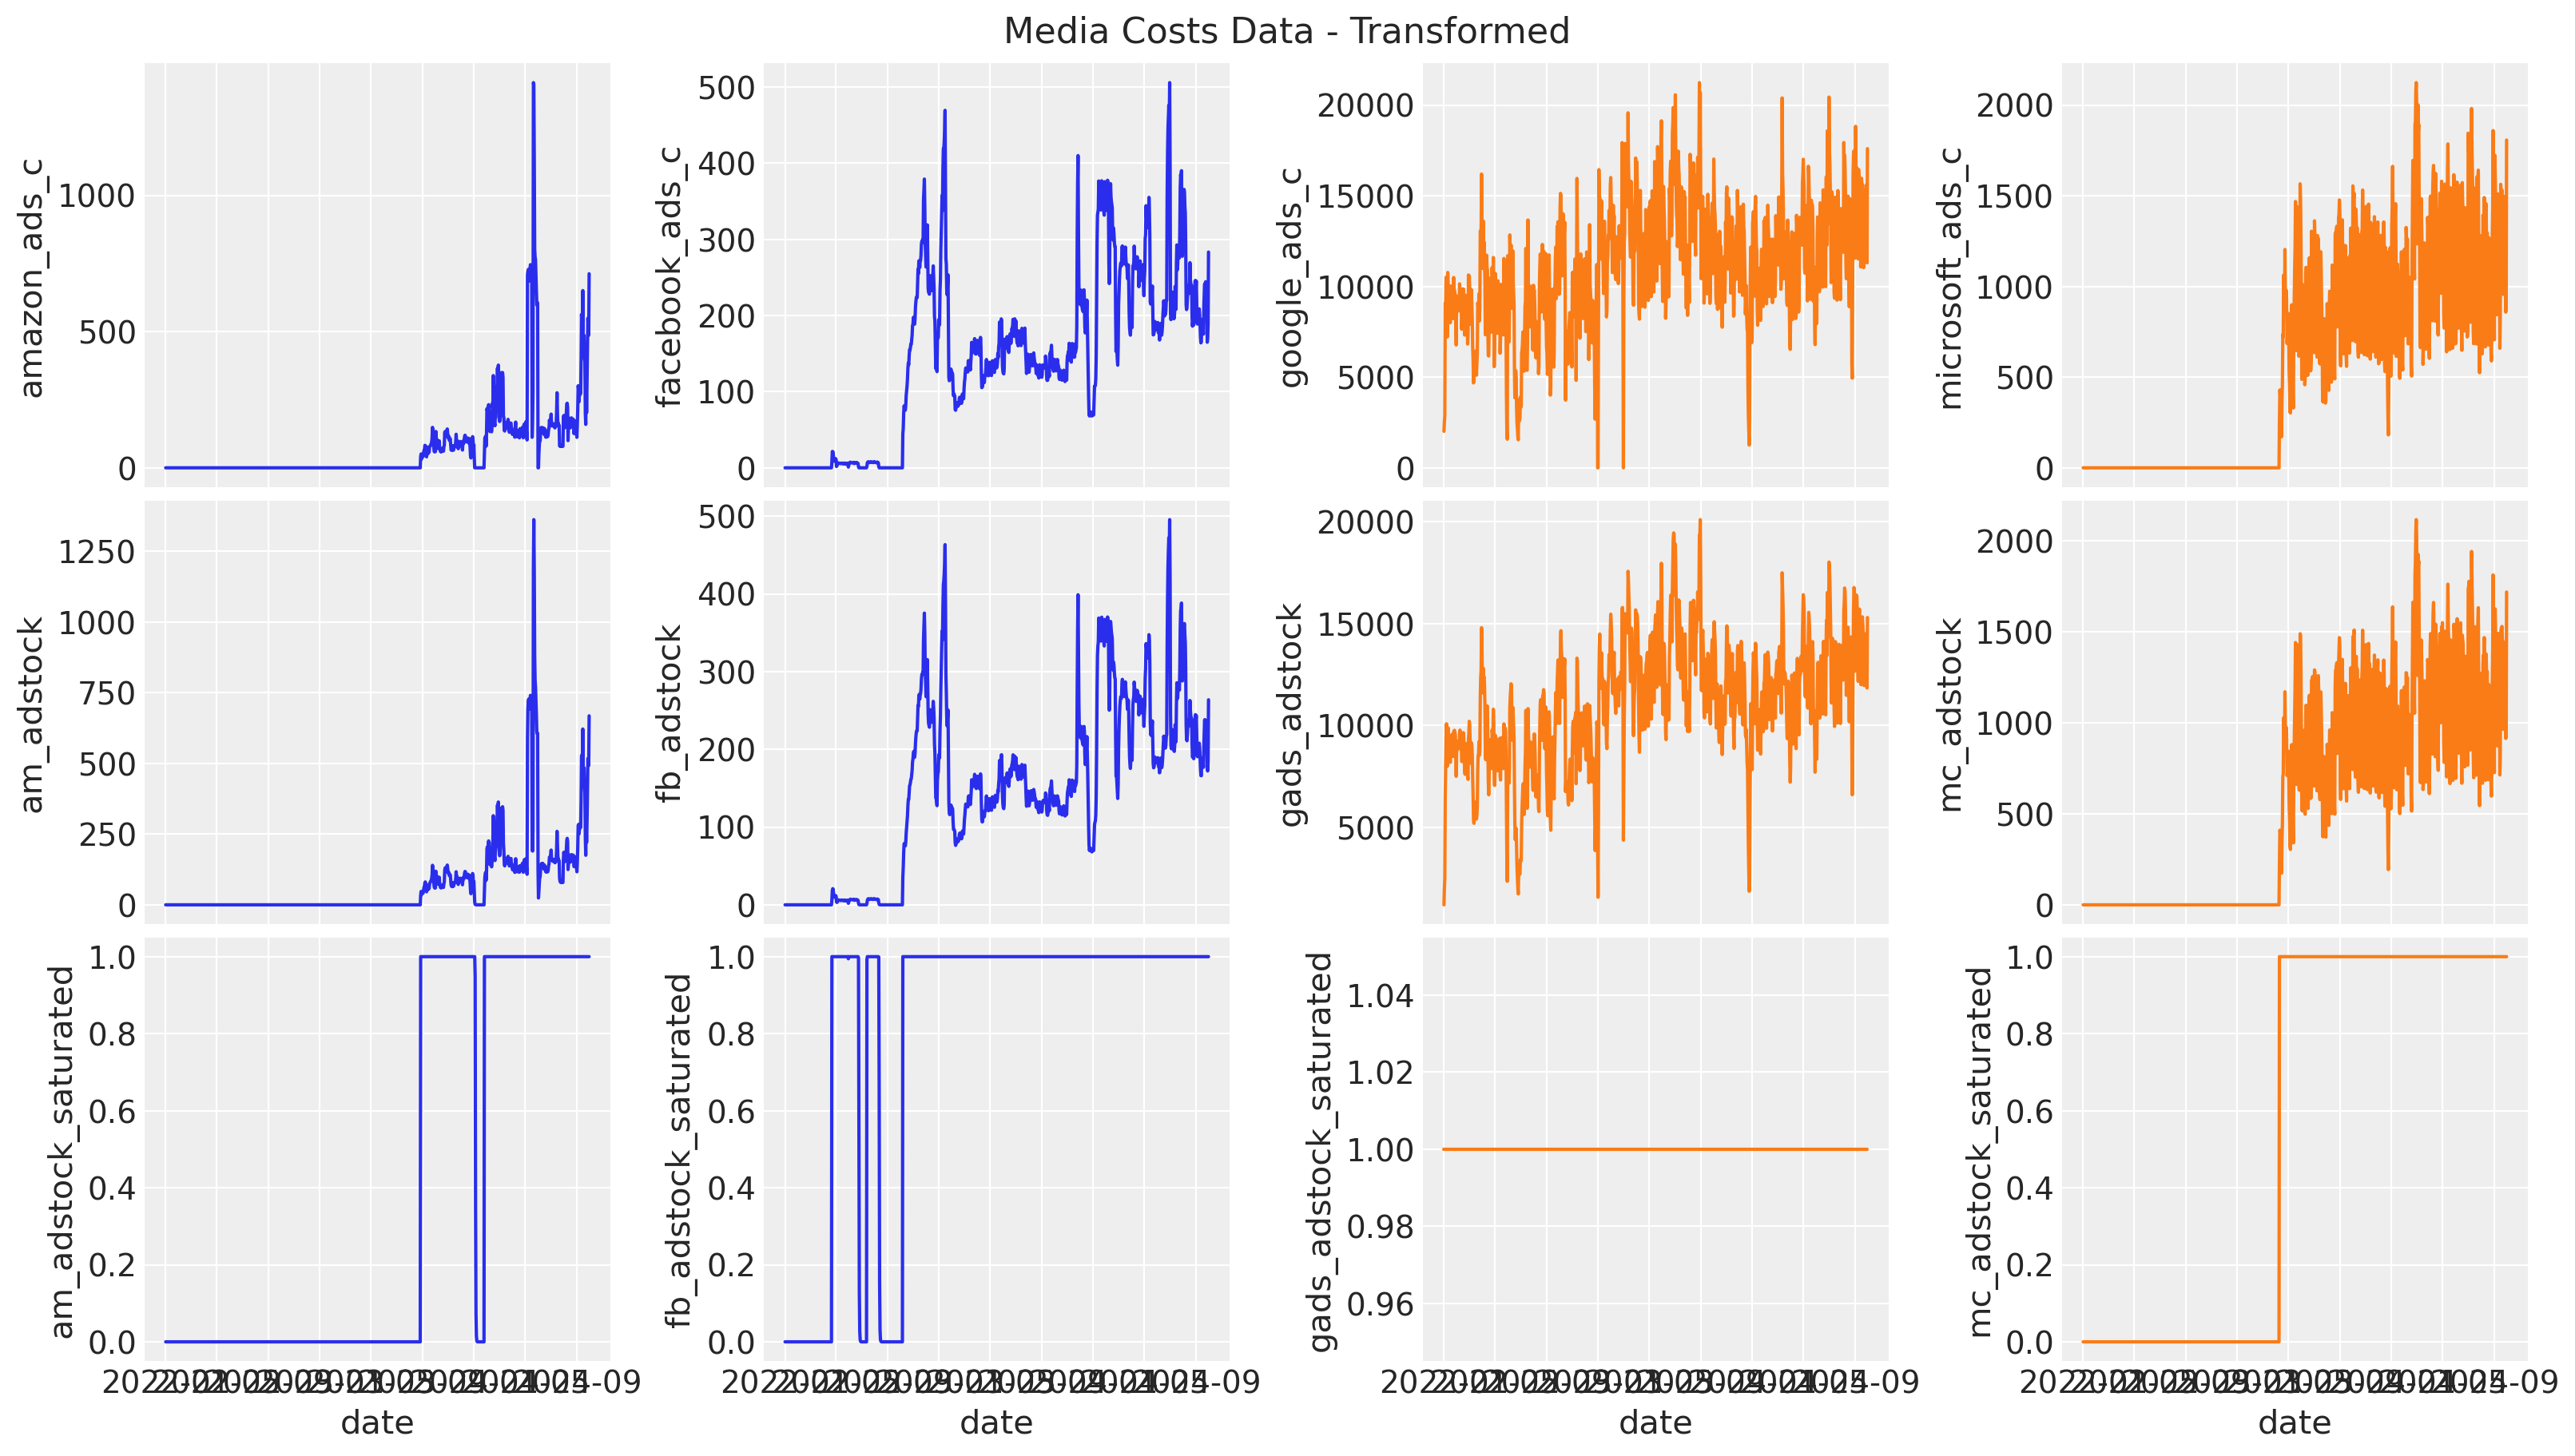

In [13]:
fig, ax = plt.subplots(
    nrows=3, ncols=4, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date", y="amazon_ads_c", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date", y="facebook_ads_c", data=df, color="C0", ax=ax[0, 1])
sns.lineplot(x="date", y="google_ads_c", data=df, color="C1", ax=ax[0, 2])
sns.lineplot(x="date", y="microsoft_ads_c", data=df, color="C1", ax=ax[0, 3])
sns.lineplot(x="date", y="am_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date", y="fb_adstock", data=df, color="C0", ax=ax[1, 1])
sns.lineplot(x="date", y="gads_adstock", data=df, color="C1", ax=ax[1, 2])
sns.lineplot(x="date", y="mc_adstock", data=df, color="C1", ax=ax[1, 3])
sns.lineplot(x="date", y="am_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date", y="fb_adstock_saturated", data=df, color="C0", ax=ax[2, 1])
sns.lineplot(x="date", y="gads_adstock_saturated", data=df, color="C1", ax=ax[2, 2])
sns.lineplot(x="date", y="mc_adstock_saturated", data=df, color="C1", ax=ax[2, 3])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

In [14]:
df = df.drop(columns=['cs','cc'])
df.head()

,date,amazon_ads_c,facebook_ads_c,google_ads_c,microsoft_ads_c,sales,weekday,yearday,month,trend,seasonality,gads_adstock,fb_adstock,am_adstock,mc_adstock,gads_adstock_saturated,fb_adstock_saturated,am_adstock_saturated,mc_adstock_saturated
0,2022-01-01,0.0,0.0,2012.716790,0.0,1023.0,5,1,1,0.778279,0.482739,1208.422025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2022-01-02,0.0,0.0,2513.760762,0.0,1248.0,6,2,1,0.780491,0.465350,1992.614367,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2022-01-03,0.0,0.0,2866.456807,0.0,1468.0,0,3,1,0.782695,0.447855,2518.047707,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2022-01-04,0.0,0.0,9075.538446,0.0,2807.0,1,4,1,0.784891,0.430272,6456.113137,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2022-01-05,0.0,0.0,8763.008392,0.0,2676.0,2,5,1,0.787079,0.412624,7843.698305,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
df = df.drop(columns=['weekday','yearday', 'month'])
df.head()

,date,amazon_ads_c,facebook_ads_c,google_ads_c,microsoft_ads_c,sales,trend,seasonality,gads_adstock,fb_adstock,am_adstock,mc_adstock,gads_adstock_saturated,fb_adstock_saturated,am_adstock_saturated,mc_adstock_saturated
0,2022-01-01,0.0,0.0,2012.716790,0.0,1023.0,0.778279,0.482739,1208.422025,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2022-01-02,0.0,0.0,2513.760762,0.0,1248.0,0.780491,0.465350,1992.614367,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2022-01-03,0.0,0.0,2866.456807,0.0,1468.0,0.782695,0.447855,2518.047707,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,2022-01-04,0.0,0.0,9075.538446,0.0,2807.0,0.784891,0.430272,6456.113137,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,2022-01-05,0.0,0.0,8763.008392,0.0,2676.0,0.787079,0.412624,7843.698305,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [16]:
total_spend_per_channel = df[["amazon_ads_c", 'facebook_ads_c', 'google_ads_c', 'microsoft_ads_c']].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

amazon_ads_c       0.005890
facebook_ads_c     0.011974
google_ads_c       0.934137
microsoft_ads_c    0.047999
dtype: float64

In [17]:
n_channels = 4

prior_sigma = n_channels * spend_share.to_numpy()

prior_sigma.tolist()

[0.023561745325990965,
 0.047895001731177965,
 3.7365465993325704,
 0.1919966536102602]

In [18]:
data = df
X = data.drop("sales", axis=1)
y = data["sales"]

In [19]:
my_model_config = {
    "intercept": {"dist": "Normal", "kwargs": {"mu": 0, "sigma": 0.5}},
    "saturation_beta": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": prior_sigma},
    },
    "gamma_control": {
        "dist": "Normal",
        "kwargs": {"mu": 0, "sigma": 0.05},
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 0.2},
    },
    "likelihood": {
        "dist": "Normal",
        "kwargs": {
            "sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}
            # Also possible define sigma as:
            # {'sigma': 5}
        },
    },
}

In [20]:
my_sampler_config = {"progressbar": True}

In [21]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="date",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=["amazon_ads_c", 'facebook_ads_c', 'google_ads_c', 'microsoft_ads_c'],
    control_columns=[
        "trend",
        'seasonality'
    ],
    yearly_seasonality=2,
)

In [22]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
mmm.fit(X=X, y=y, target_accept=0.85, chains=4, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, gamma_fourier, y_sigma]


/opt/anaconda3/envs/marketing_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

ValueError: Not enough samples to build a trace.

In [ ]:
mmm.save("model.nc")

In [23]:
mmm.load("model.nc")

In [24]:
type(mmm.model)

pymc.model.core.Model

In [25]:
print(f"Model was train using the {mmm.saturation.__class__.__name__} function")
print(f"and the {mmm.adstock.__class__.__name__} function")

Model was train using the LogisticSaturation function
and the GeometricAdstock function


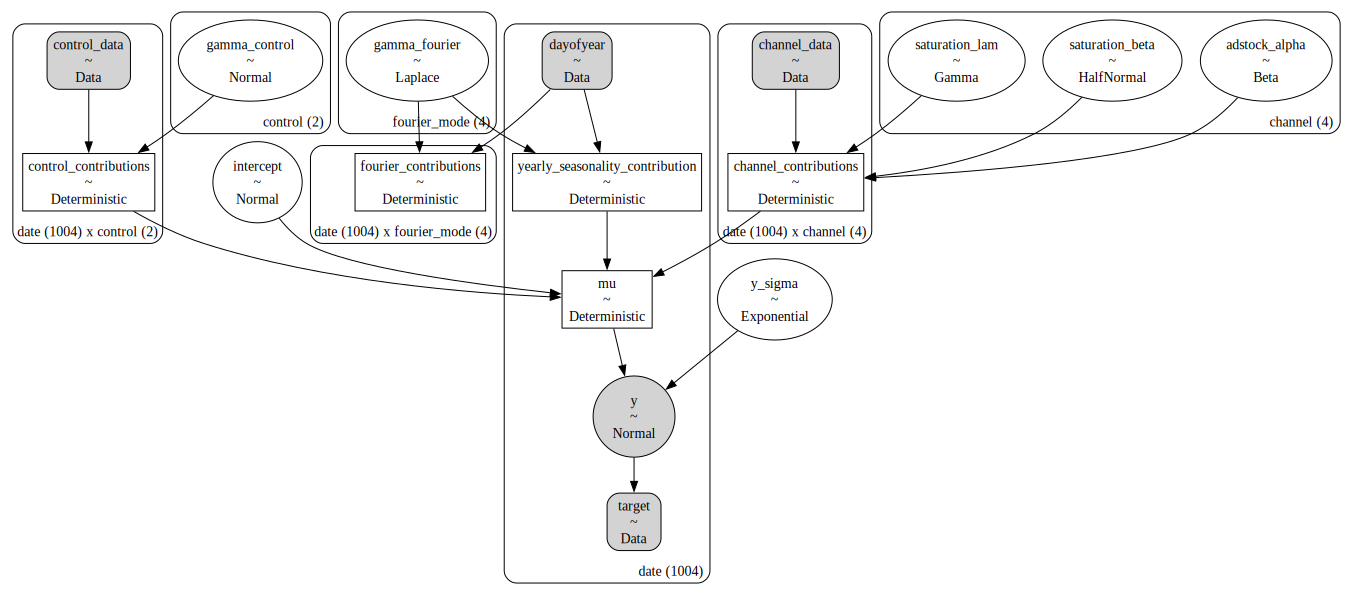

In [26]:
pm.model_to_graphviz(model=mmm.model)

In [27]:
# Number of diverging samples
mmm.idata["sample_stats"]["diverging"].sum().item()

TypeError: 'NoneType' object is not subscriptable

In [28]:
mmm.fit_result

RuntimeError: The model hasn't been fit yet, call .fit() first

In [29]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

TypeError: Unsupported type for `trace` argument: <class 'NoneType'>.

In [ ]:
mmm.plot_posterior_predictive(original_scale=True);

In [ ]:
mmm.plot_posterior_predictive(add_hdi=False, add_mean=False, add_gradient=True);

In [ ]:
mmm.plot_errors(original_scale=True);

In [ ]:
errors = mmm.get_errors(original_scale=True)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

In [ ]:
last_date = X["date"].max()

# New dates starting from last in dataset
n_new = 5
new_dates = pd.date_range(start=last_date, periods=1 + n_new, freq="W-MON")[1:]

X_out_of_sample = pd.DataFrame(
    {
        "date": new_dates,
    }
)

# Same channel spends as last day
X_out_of_sample["google_ads_c"] = X["google_ads_c"].iloc[-1]
X_out_of_sample["amazon_ads_c"] = X["amazon_ads_c"].iloc[-1]
X_out_of_sample["facebook_ads_c"] = X["facebook_ads_c"].iloc[-1]
X_out_of_sample["microsoft_ads_c"] = X["microsoft_ads_c"].iloc[-1]

# Other features
X_out_of_sample["trend"] = range(len(X), len(X) + n_new)
X_out_of_sample["seasonality"] = range(len(X), len(X) + n_new)

X_out_of_sample

In [ ]:
X_out_of_sample.info()

In [ ]:
y_out_of_sample = mmm.sample_posterior_predictive(
    X_pred=X_out_of_sample, extend_idata=False
)

y_out_of_sample

In [ ]:
def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X["date"])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample["date"].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(
    X_out_of_sample, y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left");